# Steady-State Distillation  Model

In [1]:
import numpy as np
from scipy.optimize import fsolve
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Antoine constants for saturate vapor pressure for 
# i-butane, n-butane, i-pentane, n-pentane, n-hexane
# form of the equation is
# p_sat (psia) = A - B / (C + T(F))
# above data from E.g. 8-11 in the textbook by Foust, et. al.

Antoine_A = np.array((5.03458, 5.11679, 5.07617, 5.13871, 5.16426))
Antoine_B = np.array((1589.04, 1702.62, 1836.0216, 1916.334, 2108.754))
Antoine_C = np.array((400, 400, 387.575, 385.6, 371.859))

In [3]:
class Unit():
    def __init__(self, name, num):
        self.xvar = None
        self.eqns = None
        self.unit_dict = dict()
        if name is None:
            self.name = type(self).__name__ + str(num)
        else:
            self.name = name
        
    def num_eqns(self):
        num = self.n_eqns
        for u in self.unit_dict:
            num += self.unit_dict[u].num_eqns()
        return num        

    def num_vars(self):
        num = self.n_vars
        for u in self.unit_dict:
            num += self.unit_dict[u].num_vars()
        return num        

In [4]:
class Stream(Unit):
    
    n_streams = 0
    
    def __init__(self, n_comps=1, name=None):
        self.stream_num = Stream.n_streams
        super().__init__(name, self.stream_num)
        Stream.n_streams += 1
        # the stream member x_var will be as follows:
        # [0] flow rate
        # [1] temperature
        # [2:] fraction of each component. if flow is in mass units, these are mass fractions
        self.n_comps = n_comps
        self.n_vars = 2 + n_comps
        self.n_eqns = 0
        
    def __str__(self):
        s = 'Stream name: {}\n'.format(self.name)
        s = s + 'Stream number: {}\n'.format(self.stream_num)
        s = s + 'Number of variables: {}\n'.format(self.n_vars)
        s = s + 'Number of equations: {}\n'.format(self.n_eqns)
        if self.xvar is None:
            s = s + 'Variables not set\n'
        else:
            s = s + 'Flow rate: {}\n'.format(self.xvar[0])
            s = s + 'Temperature: {}\n'.format(self.xvar[1])
            s = s + 'Fractions: {}\n'.format(self.xvar[2:])
        return s
    
    def calculate(self):
        pass

In [5]:
class Mixer(Unit):
    
    n_mixers = 0
    
    def __init__(self, streams_in, streams_out, name=None):
        self.mixer_num = Mixer.n_mixers
        super().__init__(name, self.mixer_num)
        Mixer.n_mixers += 1
        self.streams_in = streams_in
        self.streams_out = streams_out
        self.n_in = len(self.streams_in)
        self.n_out = len(self.streams_out)
        self.n_vars = 0
        self.n_eqns = (self.streams_in[0].n_comps + 1) * self.n_out + 1

    def __str__(self):
        s = ''
        s = s + 'Mixer name: {}\n'.format(self.name)
        s = s + 'Mixer number: {}\n'.format(self.mixer_num)
        s = s + 'Number of variables: {}\n'.format(self.n_vars)
        s = s + 'Number of equations: {}\n'.format(self.n_eqns)
        s_in = list()
        for stream in self.streams_in:
            s_in.append(stream.name)
        s = s + 'Streams in: {}\n'.format(','.join(s_in))
        s_out = list()
        for stream in self.streams_out:
            s_out.append(stream.name)
        s = s + 'Streams out: {}\n'.format(', '.join(s_out))
        s = s + 'Number of equations: {}\n'.format(self.n_eqns)
        if self.eqns is None:
            s = s + 'Equations not set\n'
        else:
            s = s + 'Equations: {}\n'.format(self.eqns[:])
        return s
    
    def calculate(self):
        # total mass balance: 1 equation
        total_in = 0
        for s in self.streams_in:
            total_in += s.xvar[0]
        total_out = 0
        for s in self.streams_out:
            total_out += s.xvar[0]
        self.eqns[0] = total_in - total_out
        # heat balance (simple: temp out is weighted average of temp in. n_out equations)
        t_avg_in = 0
        for s in self.streams_in:
            t_avg_in += s.xvar[0] * s.xvar[1]
        if total_in == 0:
            t_avg_in = self.streams_in[0].xvar[1]
        else:
            t_avg_in = t_avg_in / total_in
        eq_n = 0
        for s in self.streams_out:
            eq_n += 1
            self.eqns[eq_n] = t_avg_in - s.xvar[1]
        # component balances (n_out * n_comps equations)
        for i_comp in range(self.streams_in[0].n_comps):
            comp_in = 0
            for s in self.streams_in:
                comp_in += s.xvar[2 + i_comp] * s.xvar[0]
            if total_in == 0:
                comp_in = self.streams_in[0].xvar[2 + i_comp]
            else:
                comp_in = comp_in / total_in
            for s in self.streams_out:
                eq_n += 1
                self.eqns[eq_n] = comp_in - s.xvar[2 + i_comp]
        return

In [6]:
class Connector(Unit):
    
    n_connectors = 0
    
    def __init__(self, stream_in, stream_out, name=None):
        self.connector_num = Connector.n_connectors
        super().__init__(name, self.connector_num)
        Connector.n_connectors += 1
        self.stream_in = stream_in
        self.stream_out = stream_out
        self.n_vars = 0
        self.n_eqns = self.stream_in.n_comps + 2

    def __str__(self):
        s = ''
        s = s + 'Connector number: {}\n'.format(self.connector_num)
        s = s + 'Stream in: {}\n'.format(self.stream_in.name)
        s = s + 'Stream out: {}\n'.format(self.stream_out.name)
        s = s + 'Number of variables: {}\n'.format(self.n_vars)
        s = s + 'Number of equations: {}\n'.format(self.n_eqns)
        if self.eqns is None:
            s = s + 'Equations not set\n'
        else:
            s = s + 'Equations: {}\n'.format(self.eqns[:])
        return s
    
    def calculate(self):
        # equate flow: 1 equation
        self.eqns[0] = self.stream_in.xvar[0] - self.stream_out.xvar[0]
        # equate temperature: 1 equation
        self.eqns[1] = self.stream_in.xvar[1] - self.stream_out.xvar[1]
        # equate component fractions: n_comps equations
        for i_comp in range(self.stream_in.n_comps):
            self.eqns[2 + i_comp] = self.stream_in.xvar[2 + i_comp] - self.stream_out.xvar[2 + i_comp]
        return

In [7]:
class Specify(Unit):
    
    n_specs = 0
    
    def __init__(self, name=None, flow=False, temperature=False, fraction=False, 
                 stream=None, comp_num=None, value=None):
        self.spec_num = Specify.n_specs
        super().__init__(name, self.spec_num)
        Specify.n_specs += 1
        assert flow + temperature + fraction == 1, 'Too many/few specifications for ' + self.name
            
        self.flow = flow
        self.temperature = temperature
        self.fraction = fraction
        self.stream = stream
        self.comp_num = comp_num
        self.value = value
        self.n_vars = 0
        self.n_eqns = 1

    def __str__(self):
        s = ''
        s = s + 'Specification name: {}\n'.format(self.name)
        s = s + 'Stream : {}\n'.format(self.stream.name)
        s = s + 'Number of variables: {}\n'.format(self.n_vars)
        s = s + 'Number of equations: {}\n'.format(self.n_eqns)
        if self.flow:
            s = s + 'Flow: {}\n'.format(self.value)
        elif self.temperature:
            s = s + 'Temperature: {}\n'.format(self.value)
        elif self.fraction:
            s = s + 'Fraction: component {}, value: {}\n'.format(self.comp_num, self.value)            
            
        if self.eqns is None:
            s = s + 'Equations not set\n'
        else:
            s = s + 'Equations: {}\n'.format(self.eqns[:])
        return s
    
    def calculate(self):
        if self.flow:
            self.eqns[0] = self.value -  self.stream.xvar[0]
        if self.temperature:
            self.eqns[0] = self.value -  self.stream.xvar[1]
        if self.fraction:
            self.eqns[0] = self.value -  self.stream.xvar[2 + self.comp_num]
        return

In [8]:
class Tray(Unit):
    
    n_trays = 0
    
    def __init__(self, liq_stream_in, liq_stream_out, vap_stream_in, vap_stream_out, press, name=None):
        self.tray_num = Tray.n_trays
        super().__init__(name, self.tray_num)
        Tray.n_trays += 1
        self.liq_stream_in = liq_stream_in
        self.liq_stream_out = liq_stream_out
        self.vap_stream_in = vap_stream_in
        self.vap_stream_out = vap_stream_out
        self.press = press
        self.n_vars = 0
        self.n_eqns = 2 * self.liq_stream_in.n_comps + 4

    def __str__(self):
        s = ''
        s = s + 'Tray name: {}\n'.format(self.name)
        s = s + 'Tray number: {}\n'.format(self.tray_num)
        s = s + 'Liquid stream in: {}\n'.format(self.liq_stream_in.name)
        s = s + 'Liquid stream out: {}\n'.format(self.liq_stream_out.name)
        s = s + 'Vapor stream in: {}\n'.format(self.vap_stream_in.name)
        s = s + 'Vapor stream out: {}\n'.format(self.vap_stream_out.name)
        s = s + 'Pressure: {}\n'.format(self.press)
        s = s + 'Number of variables: {}\n'.format(self.n_vars)
        s = s + 'Number of equations: {}\n'.format(self.n_eqns)
        if self.eqns is None:
            s = s + 'Equations not set\n'
        else:
            s = s + 'Equations: {}\n'.format(self.eqns[:])
        return s
    
    def calculate(self):
        # total mass balance: 1 equation
        self.eqns[0] = self.liq_stream_in.xvar[0] + self.vap_stream_in.xvar[0] - \
            self.liq_stream_out.xvar[0] - self.vap_stream_out.xvar[0]
        # heat balance (simple: equimolal overflow. 1 equation)
        self.eqns[1] = self.liq_stream_in.xvar[0] - self.liq_stream_out.xvar[0]
        # heat balance (simple: liquid and vapor leaving tray have the same temperatures. 1 equation)
        self.eqns[2] = self.vap_stream_out.xvar[1] - self.liq_stream_out.xvar[1]
        # fractions sum to one (2 equations)
        sum_x = -1
        sum_y = -1
        for i_comp in range(self.liq_stream_in.n_comps):
            sum_x += self.liq_stream_out.xvar[2+i_comp]
            sum_y += self.vap_stream_out.xvar[2+i_comp]
        self.eqns[3] = sum_x
        self.eqns[4] = sum_y
        # component balances (n_comps equations)
        for i_comp in range(self.liq_stream_in.n_comps-1):
            self.eqns[5+i_comp] = self.liq_stream_in.xvar[0] * self.liq_stream_in.xvar[2+i_comp] + \
                self.vap_stream_in.xvar[0] * self.vap_stream_in.xvar[2+i_comp] - \
                self.liq_stream_out.xvar[0] * self.liq_stream_out.xvar[2+i_comp] - \
                self.vap_stream_out.xvar[0] * self.vap_stream_out.xvar[2+i_comp]
        # vapor-liquid equilibrium (n_comps equations)
        for i_comp in range(self.liq_stream_in.n_comps):
            K_eq = np.power(10, Antoine_A[i_comp] - Antoine_B[i_comp] / (Antoine_C[i_comp] + self.liq_stream_out.xvar[1])) / self.press
            self.eqns[4+self.liq_stream_in.n_comps+i_comp] = self.vap_stream_out.xvar[2+i_comp] - \
                K_eq * self.liq_stream_out.xvar[2+i_comp]
        return

In [9]:
class SimpleColumn(Unit):
    
    n_columns = 0
    
    def __init__(self, n_trays, feed_tray, feed_stream_liq, reflux, vapor_reboil, condensate,
                 bottoms, press, name=None):
        '''
        feed_tray must be an integer between 1 and n_trays-2 (feed cannot be to the top or bottom trays for now)
        the bottom tray is tray number zero
        the top tray is tray number n_trays-1
        '''
        self.column_num = SimpleColumn.n_columns
        super().__init__(name, self.column_num)
        SimpleColumn.n_columns += 1
        
        assert n_trays > 0, '{}: Number of tray must be greater than zero (specified {})'.format(self.name, n_trays)
        self.n_trays = n_trays
        
        assert (feed_tray >= 1) and (feed_tray <= self.n_trays-2), \
            '{}: Feed tray number must be from 1 to {} inclusive (specified {}). No feed to the top or bottom trays for now' \
            .format(self.name, self.n_trays-2, feed_tray)
        self.feed_tray = feed_tray
        
        self.feed_stream_liq = feed_stream_liq
        self.reflux = reflux
        self.vapor_reboil = vapor_reboil
        self.condensate = condensate
        self.bottoms = bottoms
        self.press = press
        self.n_vars = 0
        self.n_eqns = 0
        
        # figure out number of streams to be created as part of this column
        # for each tray, there are two streams leaving (one liquid, one vapor)
        # one liquid feed stream (comes from outside the column)
        # one stream that is a combination of the liquid feed stream and the liquid from the tray above the feed tray
        
        # create the streams associated with the column
        # tray liquid and vapor streams
        self.tray_liq_stream = []
        for i_tray in range(self.n_trays):
            name = self.name+'Tray'+str(i_tray)+'Liquid'
            self.tray_liq_stream.append(Stream(n_comps=N_COMPS, name=name))

        self.tray_vap_stream = []
        for i_tray in range(self.n_trays):
            name = self.name+'Tray'+str(i_tray)+'Vapor'
            self.tray_vap_stream.append(Stream(n_comps=N_COMPS, name=name))

        # create the mixed stream consisting of the feed stream and the liquid from the tray above the feed tray
        name = self.name+'MixedLiquidFeed'
        self.mixed_liq_feed = Stream(n_comps=N_COMPS, name=name)
        self.unit_dict[name] = self.mixed_liq_feed
        
        # create the mixer needed to mix the liquid feed and the liquid from the tray above the feed tray
        name=self.name+'FeedMixer'
        self.feed_mixer = Mixer(streams_in=[self.feed_stream_liq, self.tray_liq_stream[feed_tray+1]], 
                                streams_out=[self.mixed_liq_feed],
                                name=name)
        self.unit_dict[name] = self.feed_mixer
        
        # create trays
        self.trays = []
        for i_tray in range(self.n_trays):
            name=self.name+'Tray'+str(i_tray)
            if i_tray == self.feed_tray:
                self.trays.append(Tray(liq_stream_in=self.mixed_liq_feed, 
                                       liq_stream_out=self.tray_liq_stream[i_tray],
                                       vap_stream_in=self.tray_vap_stream[i_tray-1], 
                                       vap_stream_out=self.tray_vap_stream[i_tray], 
                                       press=self.press, name=name))
            elif i_tray == 0:
                self.trays.append(Tray(liq_stream_in=self.tray_liq_stream[i_tray+1], 
                                       liq_stream_out=self.tray_liq_stream[i_tray],
                                       vap_stream_in=self.vapor_reboil, 
                                       vap_stream_out=self.tray_vap_stream[i_tray], 
                                       press=self.press, name=name))
            elif i_tray == self.n_trays-1:
                self.trays.append(Tray(liq_stream_in=self.reflux, 
                                       liq_stream_out=self.tray_liq_stream[i_tray],
                                       vap_stream_in=self.tray_vap_stream[i_tray-1], 
                                       vap_stream_out=self.tray_vap_stream[i_tray], 
                                       press=self.press, name=name))
            else:
                self.trays.append(Tray(liq_stream_in=self.tray_liq_stream[i_tray+1], 
                                       liq_stream_out=self.tray_liq_stream[i_tray],
                                       vap_stream_in=self.tray_vap_stream[i_tray-1], 
                                       vap_stream_out=self.tray_vap_stream[i_tray], 
                                       press=self.press, name=name))
                
        for s in self.tray_liq_stream:
            self.unit_dict[s.name] = s

        for s in self.tray_vap_stream:
            self.unit_dict[s.name] = s
        
        for s in self.trays:
            self.unit_dict[s.name] = s
        
        name = self.name+'CondensateConnector'
        self.condensate_connector = Connector(self.condensate, self.tray_vap_stream[n_trays-1], name=name)
        self.unit_dict[name] = self.condensate_connector
            
        name = self.name+'BottomsConnector'
        self.bottoms_connector = Connector(self.bottoms, self.tray_liq_stream[0], name=name)
        self.unit_dict[name] = self.bottoms_connector
            
    def __str__(self):
        s = ''
        s = s + 'SimpleColumn name: {}\n'.format(self.name)
        s = s + 'SimpleColumn number: {}\n'.format(self.column_num)
        s = s + 'Number of trays: {}\n'.format(self.n_trays)
        s = s + 'Feed tray: {}\n'.format(self.feed_tray)
        s = s + 'Pressure: {}\n'.format(self.press)
        s = s + 'Liquid feed stream: {}\n'.format(self.feed_stream_liq.name)
        s = s + 'Reflux stream: {}\n'.format(self.reflux.name)
        s = s + 'Vapor reboil stream: {}\n'.format(self.vapor_reboil.name)
        s = s + 'Number of variables: {}\n'.format(self.n_vars)
        s = s + 'Number of equations: {}\n'.format(self.n_eqns)
        if self.eqns is None:
            s = s + 'Equations not set\n'
        else:
            s = s + 'Equations: {}\n'.format(self.eqns[:])
        return s
        
    def calculate(self):
        for u in self.unit_dict:
            self.unit_dict[u].calculate()
            
    def profile(self):
        '''
        return a pandas data frame containing the flow, temperature and composition profiles for each of the trays
        the row for each tray contains the following columns:
        0: tray number
        1: liquid flow from tray
        2: vapor flow from tray
        3: tray temperature
        4:4+n_comps: liquid fractions
        4+n_comps:4+2*n_comps: vapor fractions
        '''
        p = np.ones((self.n_trays, 2 * self.trays[0].liq_stream_out.n_vars), dtype=np.float64) * (-1)
        n_comps = self.trays[0].liq_stream_out.n_comps
        cols = ['tray_num','L','V','T']
        cols = cols + ['{}'.format(a+str(b)) for a,b in zip(n_comps*['x'], range(n_comps))]
        cols = cols + ['{}'.format(a+str(b)) for a,b in zip(n_comps*['y'], range(n_comps))]
        for i_tray in range(self.n_trays):
            p[i_tray, 0] = i_tray
            p[i_tray, 1] = self.trays[i_tray].liq_stream_out.xvar[0]
            p[i_tray, 2] = self.trays[i_tray].vap_stream_out.xvar[0]
            p[i_tray, 3] = self.trays[i_tray].liq_stream_out.xvar[1]
            p[i_tray, 4:4+n_comps] = self.trays[i_tray].liq_stream_out.xvar[2:]
            p[i_tray, 4+n_comps:4+2*n_comps] = self.trays[i_tray].vap_stream_out.xvar[2:]
        return pd.DataFrame(data=p, columns=cols)

In [10]:
def map_var_to_unit1(x, unit_dict):

    def map_var_to_unit2(x, unit_dict, idx):
        for u in unit_dict:
            n_vars = unit_dict[u].n_vars
            if n_vars > 0:
                unit_dict[u].xvar = x[idx:idx+n_vars]
                idx += n_vars
            map_var_to_unit2(x, unit_dict[u].unit_dict, idx)

    idx = 0
    map_var_to_unit2(x, unit_dict, idx)

In [11]:
def map_eqn_to_unit1(e, unit_dict):

    def map_eqn_to_unit2(e, unit_dict, idx):
        for u in unit_dict:
            n_eqns = unit_dict[u].n_eqns
            if n_eqns > 0:
                unit_dict[u].eqns = e[idx:idx+n_eqns]
                idx += n_eqns
            map_eqn_to_unit2(e, unit_dict[u].unit_dict, idx)

    idx = 0
    map_eqn_to_unit2(e, unit_dict, idx)

In [12]:
def process_eqns(xvar):
    map_var_to_unit1(xvar, unit_dict)
    for u in unit_dict:
        unit_dict[u].calculate()
    return eqns.tolist()

# <font color='red'>Foust Column</font>

In [13]:
N_COMPS = 5

In [14]:
unit_dict = dict()

In [15]:
condensate = Stream(n_comps=N_COMPS, name='Condensate')
reflux = Stream(n_comps=N_COMPS, name='Reflux')
top_product = Stream(n_comps=N_COMPS, name='Top product')
bottoms = Stream(n_comps=N_COMPS, name='Bottoms')
vapor_reboil = Stream(n_comps=N_COMPS, name='Vapor reboil')
bottom_product = Stream(n_comps=N_COMPS, name='Bottom product')
feed = Stream(n_comps=N_COMPS, name='LiquidFeed')

In [16]:
unit_dict['condensate'] = condensate
unit_dict['reflux'] = reflux
unit_dict['top_product'] = top_product
unit_dict['bottoms'] = bottoms
unit_dict['vapor_reboil'] = vapor_reboil
unit_dict['bottom_product'] = bottom_product
unit_dict['feed'] = feed

In [17]:
condenser = Mixer(streams_in=[condensate], 
                  streams_out=[reflux, top_product], 
                  name='Condenser')

reboiler = Mixer(streams_in=[bottoms], 
                 streams_out=[vapor_reboil, bottom_product], 
                 name='Reboiler')

In [18]:
unit_dict['condenser'] = condenser
unit_dict['reboiler'] = reboiler

In [19]:
feed_flow_spec = Specify(flow=True, stream=feed, value=100)
feed_temp_spec = Specify(temperature=True, stream=feed, value=100)
feed_ic4_spec = Specify(fraction=True, stream=feed, comp_num=0, value=0.1)
feed_nc4_spec = Specify(fraction=True, stream=feed, comp_num=1, value=0.2)
feed_ic5_spec = Specify(fraction=True, stream=feed, comp_num=2, value=0.35)
feed_nc5_spec = Specify(fraction=True, stream=feed, comp_num=3, value=0.25)
feed_nc6_spec = Specify(fraction=True, stream=feed, comp_num=4, value=0.1)

top_product_flow_spec = Specify(flow=True, stream=top_product, value=30)

reflux_flow_spec = Specify(flow=True, stream=reflux, value=120)

In [20]:
unit_dict['feed_flow_spec'] = feed_flow_spec
unit_dict['feed_temp_spec'] = feed_temp_spec
unit_dict['feed_ic4_spec'] = feed_ic4_spec
unit_dict['feed_nc4_spec'] = feed_nc4_spec
unit_dict['feed_ic5_spec'] = feed_ic5_spec
unit_dict['feed_nc5_spec'] = feed_nc5_spec
unit_dict['feed_nc6_spec'] = feed_nc6_spec
unit_dict['top_product_flow_spec'] = top_product_flow_spec
unit_dict['reflux_flow_spec'] = reflux_flow_spec

In [21]:
# instantiate distillation column in E.g. 8-11 in Foust, et. al.
foust_8_11 = SimpleColumn(n_trays=15, feed_tray=8, 
                          feed_stream_liq=feed, 
                          reflux=reflux, 
                          vapor_reboil=vapor_reboil, 
                          condensate = condensate,
                          bottoms = bottoms,
                          press=55, name='foust_8_11')

In [22]:
unit_dict[foust_8_11.name] = foust_8_11

In [23]:
print(foust_8_11)

SimpleColumn name: foust_8_11
SimpleColumn number: 0
Number of trays: 15
Feed tray: 8
Pressure: 55
Liquid feed stream: LiquidFeed
Reflux stream: Reflux
Vapor reboil stream: Vapor reboil
Number of variables: 0
Number of equations: 0
Equations not set



In [24]:
n_eqns = 0
for u in unit_dict:
    n_eqns += unit_dict[u].num_eqns()
    
n_eqns

266

In [25]:
n_vars = 0
for u in unit_dict:
    n_vars += unit_dict[u].num_vars()
    
n_vars

266

In [26]:
assert n_eqns == n_vars, 'Column is NOT OK'
print('Column is OK')

Column is OK


In [27]:
xvar = np.ones(n_vars, dtype=np.float64) * 100

In [28]:
map_var_to_unit1(xvar, unit_dict)

In [29]:
eqns = np.ones(n_vars, dtype=np.float64)

In [30]:
map_eqn_to_unit1(eqns, unit_dict)

In [31]:
process_eqns(xvar);

In [32]:
x_solution = fsolve(process_eqns, xvar)

In [33]:
np.sum(np.square(eqns))

3.026437446613957e-14

In [34]:
map_var_to_unit1(x_solution, unit_dict)

In [35]:
print(top_product)

Stream name: Top product
Stream number: 2
Number of variables: 7
Number of equations: 0
Flow rate: 30.0
Temperature: 99.07349606231314
Fractions: [3.33028036e-01 6.56251375e-01 9.83823282e-03 8.82247864e-04
 1.08528267e-07]



In [36]:
print(bottom_product)

Stream name: Bottom product
Stream number: 5
Number of variables: 7
Number of equations: 0
Flow rate: 69.9999999999999
Temperature: 175.65792088168965
Fractions: [1.30841649e-04 4.46369658e-03 4.95783615e-01 3.56764751e-01
 1.42857096e-01]



In [37]:
print(reflux)

Stream name: Reflux
Stream number: 1
Number of variables: 7
Number of equations: 0
Flow rate: 120.0
Temperature: 99.07349606231314
Fractions: [3.33028036e-01 6.56251375e-01 9.83823282e-03 8.82247864e-04
 1.08528267e-07]



In [38]:
print(vapor_reboil)

Stream name: Vapor reboil
Stream number: 4
Number of variables: 7
Number of equations: 0
Flow rate: 150.00000000000009
Temperature: 175.65792088168965
Fractions: [1.30841649e-04 4.46369658e-03 4.95783615e-01 3.56764751e-01
 1.42857096e-01]



In [39]:
print(bottoms)

Stream name: Bottoms
Stream number: 3
Number of variables: 7
Number of equations: 0
Flow rate: 220.0
Temperature: 175.65792088168962
Fractions: [1.30841649e-04 4.46369658e-03 4.95783615e-01 3.56764751e-01
 1.42857096e-01]



In [40]:
print(condensate)

Stream name: Condensate
Stream number: 0
Number of variables: 7
Number of equations: 0
Flow rate: 150.0
Temperature: 99.07349606231314
Fractions: [3.33028036e-01 6.56251375e-01 9.83823282e-03 8.82247864e-04
 1.08528267e-07]



In [41]:
foust_profile = foust_8_11.profile()

In [42]:
foust_profile.head()

,tray_num,L,V,T,x0,x1,x2,x3,x4,y0,y1,y2,y3,y4
0,0.0,220.0,150.0,175.657921,0.000131,0.004464,0.495784,0.356765,0.142857,0.000447,0.011707,0.590620,0.343854,0.053372
1,1.0,220.0,150.0,171.440036,0.000347,0.009402,0.560445,0.347962,0.081844,0.001131,0.023449,0.630890,0.315988,0.028543
2,2.0,220.0,150.0,169.347930,0.000812,0.017408,0.587902,0.328962,0.064916,0.002588,0.042336,0.643261,0.289945,0.021870
3,3.0,220.0,150.0,167.450325,0.001806,0.030285,0.596336,0.311206,0.060366,0.005633,0.071976,0.635774,0.266912,0.019706
4,4.0,220.0,150.0,164.950807,0.003882,0.050495,0.591231,0.295502,0.058890,0.011765,0.116392,0.608981,0.244427,0.018435


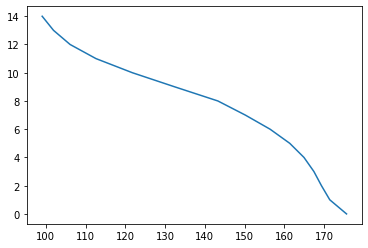

In [43]:
plt.plot(foust_profile['T'], foust_profile['tray_num'], '-')

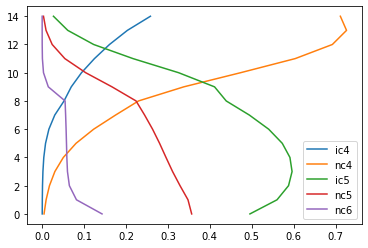

In [44]:
plt.plot(foust_profile['x0'], foust_profile['tray_num'], '-')
plt.plot(foust_profile['x1'], foust_profile['tray_num'], '-')
plt.plot(foust_profile['x2'], foust_profile['tray_num'], '-')
plt.plot(foust_profile['x3'], foust_profile['tray_num'], '-')
plt.plot(foust_profile['x4'], foust_profile['tray_num'], '-')

plt.legend(['ic4','nc4','ic5','nc5','nc6'])

# <font color='red'>TESTING</font>

In [45]:
N_COMPS = 2

## <font color='red'>Mixer that combines</font>

In [46]:
x1 = Stream(n_comps=N_COMPS, name='x1')

In [47]:
x2 = Stream(n_comps=N_COMPS, name='x2')

In [48]:
y = Stream(n_comps=N_COMPS, name='y')

In [49]:
mix = Mixer(streams_in=[x1,x2], streams_out=[y], name='mix')

In [50]:
s1f = Specify(flow=True, stream=x1, value=1)
s1t = Specify(temperature=True, stream=x1, value=100)
sx11 = Specify(fraction=True, stream=x1, comp_num=0, value=0.1)
sx12 = Specify(fraction=True, stream=x1, comp_num=1, value=0.9)

s2f = Specify(flow=True, stream=x2, value=1)
s2t = Specify(temperature=True, stream=x2, value=150)
sx21 = Specify(fraction=True, stream=x2, comp_num=0, value=0.9)
sx22 = Specify(fraction=True, stream=x2, comp_num=1, value=0.1)


In [51]:
unit_dict = dict()
unit_dict['x1'] = x1
unit_dict['x2'] = x2
unit_dict['y'] = y
unit_dict['mix'] = mix
unit_dict['s1f'] = s1f
unit_dict['s1t'] = s1t
unit_dict['sx11'] = sx11
unit_dict['sx12'] = sx12
unit_dict['s2f'] = s2f
unit_dict['s2t'] = s2t
unit_dict['sx21'] = sx21
unit_dict['sx22'] = sx22


In [52]:
n_vars = 0
for u in unit_dict:
    n_vars += unit_dict[u].num_vars()
    
n_vars

12

In [53]:
n_eqns = 0
for u in unit_dict:
    n_eqns += unit_dict[u].num_eqns()
    
n_eqns

12

In [54]:
assert n_eqns == n_vars
print('Mixer that mixes is OK')

Mixer that mixes is OK


In [55]:
xvar = np.ones(n_vars, dtype=np.float64)
eqns = np.ones(n_eqns, dtype=np.float64)

In [56]:
map_var_to_unit1(xvar, unit_dict)
map_eqn_to_unit1(eqns, unit_dict)

In [57]:
x_soln = fsolve(process_eqns, xvar)

In [58]:
x_soln

array([1.00e+00, 1.00e+02, 1.00e-01, 9.00e-01, 1.00e+00, 1.50e+02,
       9.00e-01, 1.00e-01, 2.00e+00, 1.25e+02, 5.00e-01, 5.00e-01])

In [59]:
map_var_to_unit1(x_soln, unit_dict)

In [60]:
print(x1)

Stream name: x1
Stream number: 38
Number of variables: 4
Number of equations: 0
Flow rate: 1.0
Temperature: 100.0
Fractions: [0.1 0.9]



In [61]:
print(x2)

Stream name: x2
Stream number: 39
Number of variables: 4
Number of equations: 0
Flow rate: 1.0
Temperature: 150.0
Fractions: [0.9 0.1]



In [62]:
print(y)

Stream name: y
Stream number: 40
Number of variables: 4
Number of equations: 0
Flow rate: 2.0
Temperature: 125.0
Fractions: [0.5 0.5]



In [63]:
np.sum(np.square(eqns))

0.0

## <font color='red'>Mixer that splits</font>

In [64]:
i = Stream(n_comps=N_COMPS, name='i')
o1 = Stream(n_comps=N_COMPS, name='o1')
o2 = Stream(n_comps=N_COMPS, name='o2')

In [65]:
split = Mixer(streams_in=[i], streams_out=[o1,o2], name='split')

In [66]:
sif = Specify(flow=True, stream=i, value=1)
sit = Specify(temperature=True, stream=i, value=100)
si1 = Specify(fraction=True, stream=i, comp_num=0, value=0.1)
si2 = Specify(fraction=True, stream=i, comp_num=1, value=0.9)
so1f = Specify(flow=True, stream=o1, value=0.1)


In [67]:
unit_dict = dict()
unit_dict['i'] = i
unit_dict['o1'] = o1
unit_dict['o2'] = o2
unit_dict['split'] = split
unit_dict['sif'] = sif
unit_dict['sit'] = sit
unit_dict['si1'] = si1
unit_dict['si2'] = si2
unit_dict['so1f'] = so1f


In [68]:
n_vars = 0
for u in unit_dict:
    n_vars += unit_dict[u].num_vars()
    
n_vars

12

In [69]:
n_eqns = 0
for u in unit_dict:
    n_eqns += unit_dict[u].num_eqns()
    
n_eqns

12

In [70]:
assert n_eqns == n_vars
print('Mixer that splits is OK')

Mixer that splits is OK


In [71]:
xvar = np.ones(n_vars, dtype=np.float64)
eqns = np.ones(n_eqns, dtype=np.float64)

In [72]:
map_var_to_unit1(xvar, unit_dict)
map_eqn_to_unit1(eqns, unit_dict)

In [73]:
x_soln = fsolve(process_eqns, xvar)

In [74]:
x_soln

array([  1. , 100. ,   0.1,   0.9,   0.1, 100. ,   0.1,   0.9,   0.9,
       100. ,   0.1,   0.9])

In [75]:
map_var_to_unit1(x_soln, unit_dict)

In [76]:
print(i)

Stream name: i
Stream number: 41
Number of variables: 4
Number of equations: 0
Flow rate: 1.0
Temperature: 100.0
Fractions: [0.1 0.9]



In [77]:
print(o1)

Stream name: o1
Stream number: 42
Number of variables: 4
Number of equations: 0
Flow rate: 0.1
Temperature: 100.0
Fractions: [0.1 0.9]



In [78]:
print(o2)

Stream name: o2
Stream number: 43
Number of variables: 4
Number of equations: 0
Flow rate: 0.9
Temperature: 100.0
Fractions: [0.1 0.9]



In [79]:
process_eqns(x_soln)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [80]:
np.sum(np.square(eqns))

0.0

## <font color='red'>Tray</font>

In [81]:
N_COMPS = 2

lin = Stream(n_comps=N_COMPS, name='lin')
lout = Stream(n_comps=N_COMPS, name='lout')
vin = Stream(n_comps=N_COMPS, name='vin')
vout = Stream(n_comps=N_COMPS, name='vout')

linf =Specify(flow=True, stream=lin, value=1)
lint =Specify(temperature=True, stream=lin, value=1)
lin1 =Specify(fraction=True, stream=lin, comp_num=0, value=1)
lin2 =Specify(fraction=True, stream=lin, comp_num=1, value=0)

vinf =Specify(flow=True, stream=vin, value=1)
vint =Specify(temperature=True, stream=vin, value=1)
vin1 =Specify(fraction=True, stream=vin, comp_num=0, value=1/N_COMPS)
vin2 =Specify(fraction=True, stream=vin, comp_num=1, value=1/N_COMPS)

t = Tray(lin, lout, vin, vout, press=50, name=None)

unit_dict = dict()
unit_dict['lin'] = lin
unit_dict['lout'] = lout
unit_dict['vin'] = vin
unit_dict['vout'] = vout

unit_dict['linf'] = linf
unit_dict['lint'] = lint
unit_dict['lin1'] = lin1
unit_dict['lin2'] = lin2

unit_dict['vinf'] = vinf
unit_dict['vint'] = vint
unit_dict['vin1'] = vin1
unit_dict['vin2'] = vin2

unit_dict['t'] = t

In [82]:
n_vars = 0
for u in unit_dict:
    n_vars += unit_dict[u].num_vars()
    
n_vars

16

In [83]:
n_eqns = 0
for u in unit_dict:
    n_eqns += unit_dict[u].num_eqns()
    
n_eqns

16

In [84]:
assert n_eqns == n_vars
print('Tray is OK')

Tray is OK


In [85]:
xvar = np.ones(n_vars, dtype=np.float64)
eqns = np.ones(n_eqns, dtype=np.float64)

map_var_to_unit1(xvar, unit_dict)
map_eqn_to_unit1(eqns, unit_dict)

x_soln = fsolve(process_eqns, xvar)

print(x_soln)

[ 1.00000000e+00  1.00000000e+00  1.00000000e+00 -7.37481982e-27
  1.00000000e+00  8.19084234e+01  7.17019457e-01  2.82980543e-01
  1.00000000e+00  1.00000000e+00  5.00000000e-01  5.00000000e-01
  1.00000000e+00  8.19084234e+01  7.82980543e-01  2.17019457e-01]


In [86]:
map_var_to_unit1(x_soln, unit_dict)

In [87]:
print(lin)

Stream name: lin
Stream number: 44
Number of variables: 4
Number of equations: 0
Flow rate: 1.0
Temperature: 1.0
Fractions: [ 1.00000000e+00 -7.37481982e-27]



In [88]:
print(vin)

Stream name: vin
Stream number: 46
Number of variables: 4
Number of equations: 0
Flow rate: 1.0
Temperature: 1.0
Fractions: [0.5 0.5]



In [89]:
print(lout)

Stream name: lout
Stream number: 45
Number of variables: 4
Number of equations: 0
Flow rate: 1.0
Temperature: 81.9084233871274
Fractions: [0.71701946 0.28298054]



In [90]:
print(vout)

Stream name: vout
Stream number: 47
Number of variables: 4
Number of equations: 0
Flow rate: 1.0
Temperature: 81.9084233871274
Fractions: [0.78298054 0.21701946]



In [91]:
np.sum(np.square(eqns))

2.2142809900981477e-23

## <font color='red'>Column with three trays</font>

In [92]:
N_COMPS = 2

f = Stream(n_comps=N_COMPS, name='f')
r = Stream(n_comps=N_COMPS, name='r')
c = Stream(n_comps=N_COMPS, name='c')
b = Stream(n_comps=N_COMPS, name='b')
v = Stream(n_comps=N_COMPS, name='v')

sff = Specify(flow=True, stream=f, value=100)
srf = Specify(flow=True, stream=r, value=400)
svf = Specify(flow=True, stream=v, value=450)

sft = Specify(temperature=True, stream=f, value=100)
srt = Specify(temperature=True, stream=r, value=400)
svt = Specify(temperature=True, stream=v, value=450)

sfx1 = Specify(fraction=True, stream=f, comp_num=0, value=1/N_COMPS)
sfx2 = Specify(fraction=True, stream=f, comp_num=1, value=1/N_COMPS)
srx1 = Specify(fraction=True, stream=r, comp_num=0, value=1/N_COMPS)
srx2 = Specify(fraction=True, stream=r, comp_num=1, value=1/N_COMPS)
svx1 = Specify(fraction=True, stream=v, comp_num=0, value=1/N_COMPS)
svx2 = Specify(fraction=True, stream=v, comp_num=1, value=1/N_COMPS)

col = SimpleColumn(n_trays=3, feed_tray=1, 
                          feed_stream_liq=f, 
                          reflux=r, 
                          vapor_reboil=v, 
                          condensate=c,
                          bottoms=b,
                          press=55, name='col')

unit_dict = dict()

unit_dict['f'] = f
unit_dict['r'] = r
unit_dict['c'] = c
unit_dict['b'] = b
unit_dict['v'] = v

unit_dict['sff'] = sff
unit_dict['srf'] = srf
unit_dict['svf'] = svf

unit_dict['sft'] = sft
unit_dict['srt'] = srt
unit_dict['svt'] = svt

unit_dict['sfx1'] = sfx1
unit_dict['sfx2'] = sfx2
unit_dict['srx1'] = srx1
unit_dict['srx2'] = srx2
unit_dict['svx1'] = svx1
unit_dict['svx2'] = svx2

unit_dict['col'] = col

n_eqns = 0
for u in unit_dict:
    n_eqns += unit_dict[u].num_eqns()
    
n_vars = 0
for u in unit_dict:
    n_vars += unit_dict[u].num_vars()

print('\n')
print(n_vars, ' variables')
print(n_eqns, ' equations')



48  variables
48  equations


In [93]:
xvar = np.ones(n_vars, dtype=np.float64)
eqns = np.ones(n_eqns, dtype=np.float64)

In [94]:
assert n_eqns == n_vars
print('Column is OK')

Column is OK


In [95]:
map_var_to_unit1(xvar, unit_dict)

In [96]:
map_eqn_to_unit1(eqns, unit_dict)

In [97]:
process_eqns(xvar);

In [98]:
np.sum(np.square(eqns))

741218.5952249719

In [99]:
x_soln = fsolve(process_eqns, xvar)

In [100]:
print(x_soln)

[1.00000000e+02 1.00000000e+02 5.00000000e-01 5.00000000e-01
 4.00000000e+02 4.00000000e+02 5.00000000e-01 5.00000000e-01
 4.50000000e+02 9.29410549e+01 5.65790512e-01 4.34209488e-01
 5.00000000e+02 9.38244875e+01 4.40788540e-01 5.59211460e-01
 4.50000000e+02 4.50000000e+02 5.00000000e-01 5.00000000e-01
 5.00000000e+02 9.43528439e+01 4.84696850e-01 5.15303150e-01
 5.00000000e+02 9.38244875e+01 4.40788540e-01 5.59211460e-01
 5.00000000e+02 9.33161589e+01 4.63794590e-01 5.36205410e-01
 4.00000000e+02 9.29410549e+01 4.80871063e-01 5.19128937e-01
 4.50000000e+02 9.38244875e+01 5.25562279e-01 4.74437721e-01
 4.50000000e+02 9.33161589e+01 5.48787012e-01 4.51212988e-01
 4.50000000e+02 9.29410549e+01 5.65790512e-01 4.34209488e-01]


In [101]:
map_var_to_unit1(x_soln, unit_dict)
process_eqns(x_soln);
map_eqn_to_unit1(eqns, unit_dict)

In [102]:
print(eqns)

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.05705328e-09 -1.88318250e-11  1.87583282e-11
  0.00000000e+00  0.00000000e+00 -1.42108547e-14  1.11022302e-16
  0.00000000e+00 -2.37937456e-07 -1.26754163e-11 -2.06577866e-10
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.11022302e-16
  0.00000000e+00  1.95405420e-07  6.80751011e-11  1.69555259e-10
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11022302e-16
  0.00000000e+00 -3.57585463e-08  1.24511734e-10 -2.55154564e-10
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.42108547e-14  0.00000000e+00  0.00000000e+00]


In [103]:
np.sum(np.square(eqns))

9.608568800830493e-14

In [104]:
print(f)

Stream name: f
Stream number: 48
Number of variables: 4
Number of equations: 0
Flow rate: 100.0
Temperature: 100.0
Fractions: [0.5 0.5]



In [105]:
print(r)

Stream name: r
Stream number: 49
Number of variables: 4
Number of equations: 0
Flow rate: 400.0
Temperature: 400.0
Fractions: [0.5 0.5]



In [106]:
print(c)

Stream name: c
Stream number: 50
Number of variables: 4
Number of equations: 0
Flow rate: 450.0
Temperature: 92.94105485966385
Fractions: [0.56579051 0.43420949]



In [107]:
print(v)

Stream name: v
Stream number: 52
Number of variables: 4
Number of equations: 0
Flow rate: 450.0
Temperature: 450.0
Fractions: [0.5 0.5]



In [108]:
print(b)

Stream name: b
Stream number: 51
Number of variables: 4
Number of equations: 0
Flow rate: 500.0
Temperature: 93.82448747935301
Fractions: [0.44078854 0.55921146]



In [109]:
for u in col.unit_dict:
    print(u)
    print(col.unit_dict[u])
    print('\n')

colMixedLiquidFeed
Stream name: colMixedLiquidFeed
Stream number: 59
Number of variables: 4
Number of equations: 0
Flow rate: 500.0
Temperature: 94.35284388467403
Fractions: [0.48469685 0.51530315]



colFeedMixer
Mixer name: colFeedMixer
Mixer number: 5
Number of variables: 0
Number of equations: 4
Streams in: f,colTray2Liquid
Streams out: colMixedLiquidFeed
Number of equations: 4
Equations: [ 0.00000000e+00  3.05705328e-09 -1.88318250e-11  1.87583282e-11]



colTray0Liquid
Stream name: colTray0Liquid
Stream number: 53
Number of variables: 4
Number of equations: 0
Flow rate: 500.0
Temperature: 93.82448747935302
Fractions: [0.44078854 0.55921146]



colTray1Liquid
Stream name: colTray1Liquid
Stream number: 54
Number of variables: 4
Number of equations: 0
Flow rate: 500.0
Temperature: 93.316158887835
Fractions: [0.46379459 0.53620541]



colTray2Liquid
Stream name: colTray2Liquid
Stream number: 55
Number of variables: 4
Number of equations: 0
Flow rate: 400.0
Temperature: 92.94105485966

In [110]:
a_,b_ = zip(3*['x'],[1,2,3])

ValueError: too many values to unpack (expected 2)

In [ ]:
for a,b in zip(3*['x'] , [1,2,3]):
    print(a+str(b))

In [ ]:
['{}'.format(a+str(b)) for a,b in zip(3*['x'] , [1,2,3])]

In [ ]:
['{}'.format(a+str(b)) for a,b in zip(3*['x'] , range(3))]

In [ ]:
x=['a','b']+['{}'.format(a+str(b)) for a,b in zip(3*['x'] , range(3))]

In [ ]:
print(x)

In [ ]:
x